# Step 1: Preparing data 

In [25]:
from torchvision import datasets
import torch

data_folder = '../datasets/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [26]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [27]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY - {tr_targets.shape} \n\tY-Unique Values: {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000]) 
	Y-Unique Values: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

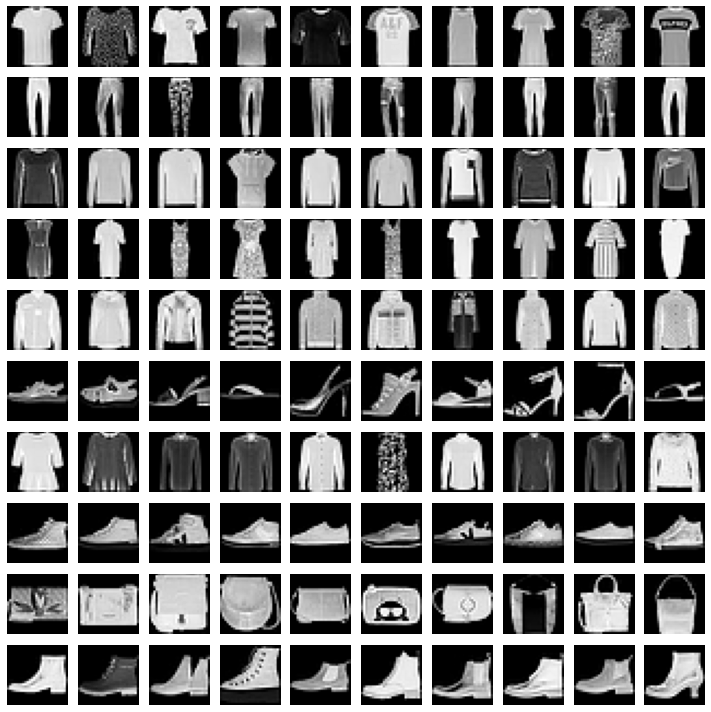

In [29]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

# Training a neural network

### 1. Import the relevant packages and the FMNIST dataset.

In [30]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Training on: {device}')

Training on: cuda


### 2. Build a class that fetches the dataset.

In [32]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

### 3. Create a function that generates a training DataLoader.

In [33]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

### 4. Define a model, as well as the loss function and the optimizer.

In [34]:
from torch.optim import SGD

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    
    return model, loss_fn, optimizer

### 5. Define a function that will train the dataset on a batch of images.

In [35]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()

    prediction = model(x)

    # compute loss
    batch_loss = loss_fn(prediction, y)

    # based on the forward pass in `model(x)` compute all the gradients of 'model.parameters()' 
    batch_loss.backward()

    # apply new-weights = f(old-weights, old-weight-gradients) where "f" is the optimizer
    optimizer.step()

    # flush gradients memory for next batch of calculations
    optimizer.zero_grad()

    return batch_loss.item()

### 6. Build a function that calculates the accuracy of a given dataset.

In [36]:
# since there's no need for updating weights, 
# we might as well not compute the gradients.
# Using this '@' decorator on top of functions 
# will disable gradient computation in the entire function
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    
    return is_correct.cpu().numpy().tolist()

### 7. Train the neural network.

In [37]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

losses, accuracies = [], []

for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)

    epoch_accuracy = np.mean(epoch_accuracies)

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


/tmp/ipykernel_7909/359997658.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


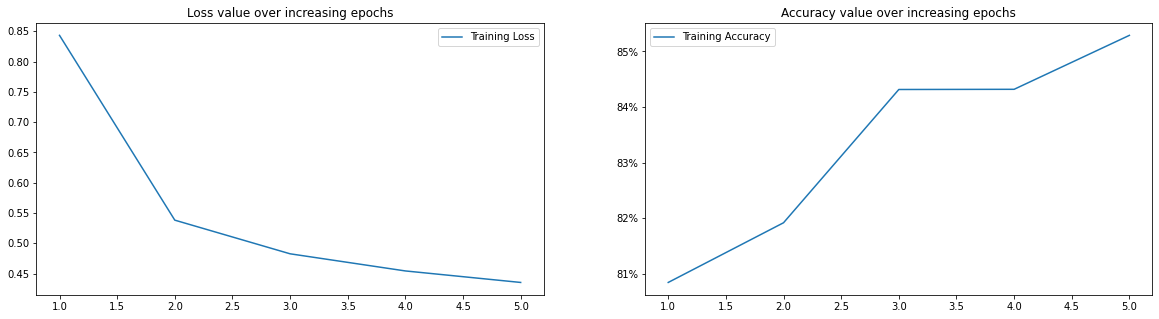

In [38]:
epochs = np.arange(5) + 1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

plt.legend()